In [1]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

----
# modify features

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [3]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

## make Cabin First character feature

In [4]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

### make dummy variable for Cabin_Letter

In [5]:
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(1309, 14)
(891, 22) (418, 21)


## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [6]:
for i in [train_df, test_df]:
    i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num1'].replace('an', np.NaN, inplace = True)
    i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
    i['Cabin_num'] = pd.qcut(train_df['Cabin_num1'], 3)

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [7]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix = 'Cabin_num')), axis = 1)

In [8]:
del train_df['Cabin_num']
del test_df['Cabin_num']
del train_df['Cabin_num1']
del test_df['Cabin_num1']

In [9]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Len',
       'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C',
       'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G',
       'Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]'],
      dtype='object')

## del Ticket, Cabin columns

In [10]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

## add title

In [11]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

----

## fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I will skip it.

----

## convert title to numerical or one hot encoding

### try one hot encoding without delete rare title

In [12]:
# try one hote encoding without delete rare title
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 24) (418, 23)
(1309, 24)
(891, 41) (418, 40)


In [13]:
train_df.columns

Index(['Age', 'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F',
       'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]', 'Embarked',
       'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket_Len', 'Title_Capt', 'Title_Col', 'Title_Countess',
       'Title_Don', 'Title_Dona', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady',
       'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme',
       'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir'],
      dtype='object')

### del rare title and map value

## make name length feature

In [14]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## map value to Sex 

In [15]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## make Age_Null_Flag if the Age is nulll

In [16]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## fill na value

### fill na of Age

#### by Sex and Pclass

In [17]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

#### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

### add age band

In [18]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [19]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Create new feature "FamilySize"

In [20]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [21]:
# keep Parch, SibSp only. this was best amoung familly related features

train_df = train_df.drop(['FamilySize', 'IsAlone'], axis=1)
test_df = test_df.drop(['FamilySize', 'IsAlone'], axis=1)
combine = [train_df, test_df]

## fill missing Embarked 

In [22]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

## Converting Embarked categorical feature to numeric

## try one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [23]:
# try one hote encoding for Embarked
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 44) (418, 43)
(1309, 44)
(891, 46) (418, 45)


## fill na of test data Fare

In [24]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

## make Fareband feature

In [25]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

## drop Name, PassengerId

In [26]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

## final check data

In [27]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [28]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,2,6,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,6,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,3,6,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,3,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,3,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


----

# model and estimate

In [29]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)

train/test data shape (596, 43) (295, 43)


## SVC

Mean cross-validated score of the best_estimator:  0.8154362416107382
best parameters: {'C': 100, 'gamma': 0.001}
test:  0.8406779661016949


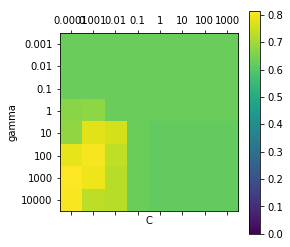

In [31]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=3)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

In [32]:
grid_search.best_estimator_.dual_coef_

array([[-100.        , -100.        , -100.        , -100.        ,
        -100.        , -100.        , -100.        , -100.        ,
          -7.43975181, -100.        , -100.        , -100.        ,
        -100.        , -100.        , -100.        ,  -31.28392538,
        -100.        , -100.        , -100.        , -100.        ,
        -100.        , -100.        ,  -73.88202569, -100.        ,
        -100.        , -100.        , -100.        , -100.        ,
        -100.        ,  -10.88303604,  -35.23619089,  -86.70386171,
         -94.02726709, -100.        , -100.        , -100.        ,
        -100.        , -100.        , -100.        ,  -19.26225998,
        -100.        , -100.        , -100.        , -100.        ,
        -100.        , -100.        ,   -9.01054356, -100.        ,
        -100.        , -100.        , -100.        ,  -94.83747243,
        -100.        , -100.        , -100.        , -100.        ,
        -100.        , -100.        , -100.     

----

# random forest result for compare

In [38]:
pipe = make_pipeline(RandomForestClassifier(max_depth=10, 
                                            max_features=1,
                                            min_samples_leaf=1, 
                                            min_samples_split=13, 
                                            n_estimators=300))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score: ", scores.mean())

test:  0.8203389830508474
mean of cross val score:  0.8226711560044894


In [36]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
35,Title_Mr,0.328918
18,Pclass,0.146335
16,Name_Len,0.123196
19,Sex,0.081773
21,Ticket_Len,0.045910
15,Fare,0.038713
42,Embarked_S,0.036164
20,SibSp,0.035131
3,Cabin_Letter_0,0.026572
1,Age*Class,0.025016


## AdaBoostClassifier

## GradientBoostingClassifier

In [37]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1, 10],
              'n_estimators': [3, 5, 7, 10, 50, 100, 200, 400, 500, 600, 700, 800, 1000],
              'min_samples_split':[2, 3, 4, 5],
              'min_samples_leaf': [1, 3, 5, 9, 17],
              'max_depth':[1,2,3,4,5,6],
              'max_features': [1, 'auto', 'sqrt', 'log2', 0.5, 0,7, 0.9],}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=3)
grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(6, -1),
            vmin=0, cmap="viridis")
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.xticks(range(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(range(len(param_grid['learning_rate'])), param_grid['learning_rate'])
plt.colorbar()

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/yuki/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/yuki/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7ff3493f1390, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/yuki/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/yuki/a.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ff3493f1390, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/yuki/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/yuki/a.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 22, 22, 34, 29, 789330, tzinfo=tzutc()), 'msg_id': '1ea580e23447b3fe299833922ab84be4', 'msg_type': 'execute_request', 'session': 'b15e2f0d7eee1ed2d0a091f17000e414', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '1ea580e23447b3fe299833922ab84be4', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'b15e2f0d7eee1ed2d0a091f17000e414']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 22, 22, 34, 29, 789330, tzinfo=tzutc()), 'msg_id': '1ea580e23447b3fe299833922ab84be4', 'msg_type': 'execute_request', 'session': 'b15e2f0d7eee1ed2d0a091f17000e414', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '1ea580e23447b3fe299833922ab84be4', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'b15e2f0d7eee1ed2d0a091f17000e414'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 22, 22, 34, 29, 789330, tzinfo=tzutc()), 'msg_id': '1ea580e23447b3fe299833922ab84be4', 'msg_type': 'execute_request', 'session': 'b15e2f0d7eee1ed2d0a091f17000e414', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '1ea580e23447b3fe299833922ab84be4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='param_grid = {\'learning_rate\': [0.001, 0.01, 0.1...rint("test: ", grid_search.score(X_test, y_test))', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-37-a11ccfbd15df>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff2f9355a58, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff32e0ebf60, file "<ipython-input-37-a11ccfbd15df>", line 9>
        result = <ExecutionResult object at 7ff2f9355a58, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/yuki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff32e0ebf60, file "<ipython-input-37-a11ccfbd15df>", line 9>, result=<ExecutionResult object at 7ff2f9355a58, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff32e0ebf60, file "<ipython-input-37-a11ccfbd15df>", line 9>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import time\n\n# data analysis and wrangling\nimpor...omModel\nfrom sklearn.feature_selection import RFE', "train_df = pd.read_csv('../input/train.csv')\ntes...../input/test.csv')\ncombine = [train_df, test_df]", "train_df['Ticket_Len'] = train_df['Ticket'].appl...y(lambda x: len(x))\ncombine = [train_df, test_df]", 'train_df["Cabin_Letter"] = train_df["Cabin"].fil...ply(lambda x: x[0])\ncombine = [train_df, test_df]', 'train_test_df = pd.concat((train_df, test_df))\n\n...pe, test_df.shape)\n\ncombine = [train_df, test_df]', "for i in [train_df, test_df]:\n    i['Cabin_num1'...'Cabin_num'] = pd.qcut(train_df['Cabin_num1'], 3)", "train_df = pd.concat((train_df, pd.get_dummies(t...f['Cabin_num'], prefix = 'Cabin_num')), axis = 1)", "del train_df['Cabin_num']\ndel test_df['Cabin_num... train_df['Cabin_num1']\ndel test_df['Cabin_num1']", 'train_df.columns', "# del Ticket, Cabin columns\ntrain_df = train_df...., 'Cabin'], axis=1)\ncombine = [train_df, test_df]", "# add title\nfor dataset in combine:\n    dataset[....Name.str.extract(' ([A-Za-z]+)\\.', expand=False)", '# try one hote encoding without delete rare titl...pe, test_df.shape)\n\ncombine = [train_df, test_df]', 'train_df.columns', "train_df['Name_Len'] = train_df['Name'].apply(la...y(lambda x: len(x))\ncombine = [train_df, test_df]", 'for dataset in combine:\n    dataset["Sex"] = dataset["Sex"].map({\'female\':1, \'male\':0}).astype(int)', "train_df['Age_Null_Flag'] = train_df['Age'].appl...d.isnull(x) else 0)\ncombine = [train_df, test_df]", "guess_ages = np.zeros((2,3))\n\nfor dataset in com...\n\n    dataset['Age'] = dataset['Age'].astype(int)", "train_df['AgeBand'] = pd.cut(train_df['Age'], 5)", "for dataset in combine:\n    dataset.loc[ dataset...'AgeBand'], axis=1)\ncombine = [train_df, test_df]", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import time\n\n# data analysis and wrangling\nimpor...omModel\nfrom sklearn.feature_selection import RFE', "train_df = pd.read_csv('../input/train.csv')\ntes...../input/test.csv')\ncombine = [train_df, test_df]", "train_df['Ticket_Len'] = train_df['Ticket'].appl...y(lambda x: len(x))\ncombine = [train_df, test_df]", 'train_df["Cabin_Letter"] = train_df["Cabin"].fil...ply(lambda x: x[0])\ncombine = [train_df, test_df]', 'train_test_df = pd.concat((train_df, test_df))\n\n...pe, test_df.shape)\n\ncombine = [train_df, test_df]', "for i in [train_df, test_df]:\n    i['Cabin_num1'...'Cabin_num'] = pd.qcut(train_df['Cabin_num1'], 3)", "train_df = pd.concat((train_df, pd.get_dummies(t...f['Cabin_num'], prefix = 'Cabin_num')), axis = 1)", "del train_df['Cabin_num']\ndel test_df['Cabin_num... train_df['Cabin_num1']\ndel test_df['Cabin_num1']", 'train_df.columns', "# del Ticket, Cabin columns\ntrain_df = train_df...., 'Cabin'], axis=1)\ncombine = [train_df, test_df]", "# add title\nfor dataset in combine:\n    dataset[....Name.str.extract(' ([A-Za-z]+)\\.', expand=False)", '# try one hote encoding without delete rare titl...pe, test_df.shape)\n\ncombine = [train_df, test_df]', 'train_df.columns', "train_df['Name_Len'] = train_df['Name'].apply(la...y(lambda x: len(x))\ncombine = [train_df, test_df]", 'for dataset in combine:\n    dataset["Sex"] = dataset["Sex"].map({\'female\':1, \'male\':0}).astype(int)', "train_df['Age_Null_Flag'] = train_df['Age'].appl...d.isnull(x) else 0)\ncombine = [train_df, test_df]", "guess_ages = np.zeros((2,3))\n\nfor dataset in com...\n\n    dataset['Age'] = dataset['Age'].astype(int)", "train_df['AgeBand'] = pd.cut(train_df['Age'], 5)", "for dataset in combine:\n    dataset.loc[ dataset...'AgeBand'], axis=1)\ncombine = [train_df, test_df]", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/yuki/github/test/kaggle/titanic/src/<ipython-input-37-a11ccfbd15df> in <module>()
      4               'min_samples_leaf': [1, 3, 5, 9, 17],
      5               'max_depth':[1,2,3,4,5,6],
      6               'max_features': [1, 'auto', 'sqrt', 'log2', 0.5, 0,7, 0.9],}
      7 
      8 grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=3)
----> 9 grid_search.fit(X_train, y_train)
     10 
     11 plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(6, -1),
     12             vmin=0, cmap="viridis")
     13 plt.xlabel("n_estimators")

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), X=     Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], y=6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X =      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns]
        y = 6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Mar 23 07:47:09 2018
PID: 8686                     Python 3.6.4: /home/yuki/anaconda3/bin/python
...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], 6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, {'score': <function _passthrough_scorer>}, array([  0,   1,   2,   3,   4,   5,   6,   7,  ...70, 472, 473, 475, 476, 477, 478, 479, 482, 484]), array([468, 469, 471, 474, 480, 481, 483, 485, 4..., 588, 589, 590, 591, 592, 593, 594,
       595]), 0, {'learning_rate': 0.001, 'max_depth': 1, 'max_features': 0.5, 'min_samples_leaf': 17, 'min_samples_split': 5, 'n_estimators': 1000}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}), (<function _fit_and_score>, (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], 6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, {'score': <function _passthrough_scorer>}, array([113, 117, 118, 120, 121, 125, 126, 127, 1...,
       588, 589, 590, 591, 592, 593, 594, 595]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 112, 114, 115, 116, 119,
       122, 123, 124]), 0, {'learning_rate': 0.001, 'max_depth': 1, 'max_features': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}), (<function _fit_and_score>, (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], 6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, {'score': <function _passthrough_scorer>}, array([  0,   1,   2,   3,   4,   5,   6,   7,  ...,
       588, 589, 590, 591, 592, 593, 594, 595]), array([113, 117, 118, 120, 121, 125, 126, 127, 1..., 232, 233, 234, 235, 237,
       238, 239, 240]), 0, {'learning_rate': 0.001, 'max_depth': 1, 'max_features': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}), (<function _fit_and_score>, (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], 6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, {'score': <function _passthrough_scorer>}, array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    587, 588, 589, 590, 591, 592, 593, 594, 595]), array([236, 241, 242, 243, 244, 245, 246, 247, 2..., 351, 352, 353, 355, 357, 359,
       360, 361]), 0, {'learning_rate': 0.001, 'max_depth': 1, 'max_features': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], 6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, {'score': <function _passthrough_scorer>}, array([113, 117, 118, 120, 121, 125, 126, 127, 1...,
       588, 589, 590, 591, 592, 593, 594, 595]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 112, 114, 115, 116, 119,
       122, 123, 124]), 0, {'learning_rate': 0.001, 'max_depth': 1, 'max_features': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), X=     Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[596 rows x 43 columns], y=6      0.0
718    0.0
685    0.0
73     0.0
882 ...  0.0
Name: Survived, Length: 596, dtype: float64, scorer={'score': <function _passthrough_scorer>}, train=array([113, 117, 118, 120, 121, 125, 126, 127, 1...,
       588, 589, 590, 591, 592, 593, 594, 595]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 112, 114, 115, 116, 119,
       122, 123, 124]), verbose=0, parameters={'learning_rate': 0.001, 'max_depth': 1, 'max_features': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseGradientBoosting.fit of Gradie...=1.0, verbose=0,
              warm_start=False)>
        X_train =      Age  Age*Class  Age_Null_Flag  Cabin_Letter...         0           1  

[476 rows x 43 columns]
        y_train = 506    1.0
530    1.0
9      1.0
22     1.0
356 ...  0.0
Name: Survived, Length: 476, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in fit(self=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), X=array([[2., 4., 0., ..., 0., 0., 1.],
       [0....   [1., 1., 0., ..., 0., 0., 1.]], dtype=float32), y=array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,...       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]), sample_weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1...1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), monitor=None)
   1029                 X_idx_sorted = np.asfortranarray(np.argsort(X, axis=0),
   1030                                                  dtype=np.int32)
   1031 
   1032         # fit the boosting stages
   1033         n_stages = self._fit_stages(X, y, y_pred, sample_weight, random_state,
-> 1034                                     begin_at_stage, monitor, X_idx_sorted)
        begin_at_stage = 0
        monitor = None
        X_idx_sorted = array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32)
   1035         # change shape of arrays after fit (early-stopping or additional ests)
   1036         if n_stages != self.estimators_.shape[0]:
   1037             self.estimators_ = self.estimators_[:n_stages]
   1038             self.train_score_ = self.train_score_[:n_stages]

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in _fit_stages(self=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), X=array([[2., 4., 0., ..., 0., 0., 1.],
       [0....   [1., 1., 0., ..., 0., 0., 1.]], dtype=float32), y=array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,...       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]), y_pred=array([[-0.52429384],
       [-0.52429384],
    ...84],
       [-0.52429384],
       [-0.52429384]]), sample_weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1...1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), random_state=<mtrand.RandomState object>, begin_at_stage=0, monitor=None, X_idx_sorted=array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32))
   1084                                       sample_weight[~sample_mask])
   1085 
   1086             # fit next stage of trees
   1087             y_pred = self._fit_stage(i, X, y, y_pred, sample_weight,
   1088                                      sample_mask, random_state, X_idx_sorted,
-> 1089                                      X_csc, X_csr)
        X_csc = None
        X_csr = None
   1090 
   1091             # track deviance (= loss)
   1092             if do_oob:
   1093                 self.train_score_[i] = loss_(y[sample_mask],

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in _fit_stage(self=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), i=0, X=array([[2., 4., 0., ..., 0., 0., 1.],
       [0....   [1., 1., 0., ..., 0., 0., 1.]], dtype=float32), y=array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,...       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]), y_pred=array([[-0.52429384],
       [-0.52429384],
    ...84],
       [-0.52429384],
       [-0.52429384]]), sample_weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1...1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), sample_mask=array([ True,  True,  True,  True,  True,  True,... True,  True,  True,  True,  True,  True,  True]), random_state=<mtrand.RandomState object>, X_idx_sorted=array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32), X_csc=None, X_csr=None)
    783             if X_csc is not None:
    784                 tree.fit(X_csc, residual, sample_weight=sample_weight,
    785                          check_input=False, X_idx_sorted=X_idx_sorted)
    786             else:
    787                 tree.fit(X, residual, sample_weight=sample_weight,
--> 788                          check_input=False, X_idx_sorted=X_idx_sorted)
        X_idx_sorted = array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32)
    789 
    790             # update tree leaves
    791             if X_csr is not None:
    792                 loss.update_terminal_regions(tree.tree_, X_csr, y, residual, y_pred,

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeRegressor(criterion='friedman_mse', ...t at 0x7ff30d7aa2d0>,
           splitter='best'), X=array([[2., 4., 0., ..., 0., 0., 1.],
       [0....   [1., 1., 0., ..., 0., 0., 1.]], dtype=float32), y=array([ 0.62815126,  0.62815126,  0.62815126,  0...4, -0.37184874,  0.62815126,
       -0.37184874]), sample_weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1...1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), check_input=False, X_idx_sorted=array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32))
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32)
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
/home/yuki/.local/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeRegressor(criterion='friedman_mse', ...t at 0x7ff30d7aa2d0>,
           splitter='best'), X=array([[2., 4., 0., ..., 0., 0., 1.],
       [0....   [1., 1., 0., ..., 0., 0., 1.]], dtype=float32), y=array([[ 0.62815126],
       [ 0.62815126],
    ...74],
       [ 0.62815126],
       [-0.37184874]]), sample_weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1...1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), check_input=False, X_idx_sorted=array([[ 58, 336,   0, ...,   0,   0, 237],
    ... 48, 231, 167, ..., 237, 280, 475]], dtype=int32))
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
--> 242             raise ValueError("max_features must be in (0, n_features]")
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:

ValueError: max_features must be in (0, n_features]
___________________________________________________________________________

In [ ]:
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.1, 
                                            max_depth=2,
                                            n_estimators=700))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)